In [ ]:
%load_ext autoreload
%autoreload 2

from rejax import PPO
from env import EnvParams, NavigationEnv

# Initialize our environment
env = NavigationEnv()

env_params = EnvParams(
    lidar_max_distance=2.0,
    lidar_fov=120,
)

config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": env_params,
    # Number of timesteps during which the agent will be trained
    "total_timesteps": 2_000_000,
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**config)

# Look at the whole configuration (we can experiment with all these parameters!)
ppo.config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'env': <env.NavigationEnv at 0x13a9a3280>,
 'env_params': {'max_steps_in_episode': 200,
  'goal_tolerance': 0.1,
  'arena_size': 5.0,
  'dt': 0.1,
  'wheel_base': 0.5,
  'max_wheel_speed': 1.0,
  'collision_penalty': 5.0,
  'robot_radius': 0.15,
  'lidar_num_beams': 32,
  'lidar_fov': 120,
  'lidar_max_distance': 2.0,
  'num_obstacles': 5,
  'min_obstacle_size': 0.3,
  'max_obstacle_size': 1.0,
  'step_penalty': 0.01,
  'goal_reward': 100.0},
 'eval_callback': <function rejax.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 2000000,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'num_envs': 64,
 'num_steps': 64,
 'num_minibatches': 16,
 'actor': {'action_dim': np.int64(2),
  'action_range': (Array([-1., -1.], dtype=float32),
   Array([1., 1.], dtype=float32)),
  'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'parent'

## Training

In [50]:
import jax
import time

# Set the seed for reproducibility
TRAIN_SEED = 13

# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 6.37898 seconds (313530 steps/second).


## Evaluation

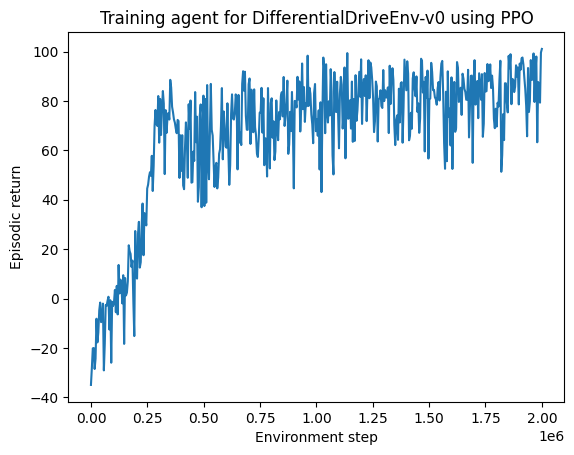

In [51]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()

Running 10 episodes and collecting frames...
  Episode 1 finished after 55 steps.
  Episode 2 finished after 40 steps.
  Episode 3 finished after 31 steps.
  Episode 4 finished after 58 steps.
  Episode 5 finished after 53 steps.
  Episode 6 finished after 24 steps.
  Episode 7 finished after 53 steps.
  Episode 8 finished after 62 steps.
  Episode 9 finished after 105 steps.
  Episode 10 finished after 26 steps.
Finished 10 episodes. Total steps: 507. Total frames: 507.
Saving GIF...
GIF saved to temp/navigation_policy.gif


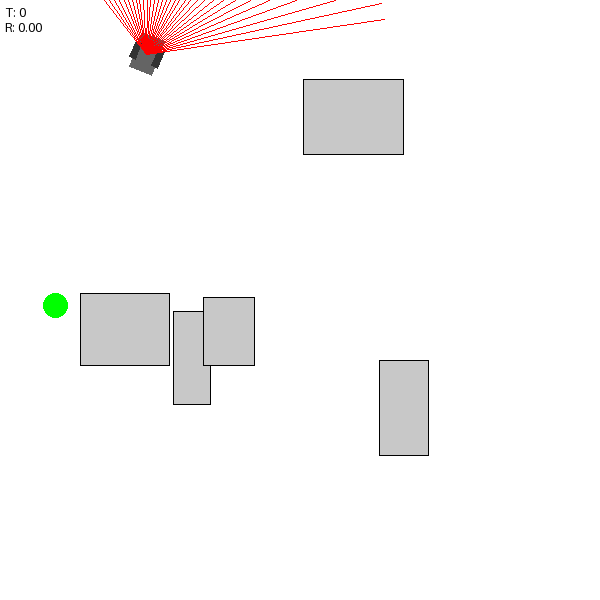

GIF saved as temp/navigation_policy.gif


In [ ]:
from IPython.display import Image as IPImage, display
import env_vis
import os

# --- Configuration ---
N_EPISODES = 10  # Number of episodes to run
TEST_SEED = 42


# --- 1. Get Agent ---
t0 = time.time()
act = jax.jit(ppo.make_act(train_state))
key = jax.random.PRNGKey(TEST_SEED)

# --- 2. Setup Test Env ---
env = NavigationEnv()

# List to store frames for GIF
frames = []
total_steps = 0  # Keep track of total steps across episodes

print(f"Running {N_EPISODES} episodes and collecting frames...")

# --- 3. Run Episodes & Collect Frames ---
for i_episode in range(N_EPISODES):
    key, reset_key = jax.random.split(key)
    obs, state = env.reset(reset_key, env_params)
    done = False
    episode_steps = 0

    while not done:
        # Render current state to frame
        frame = env_vis.render_frame(state, env_params)
        frames.append(frame)

        # Choose action and step environment
        key, act_key, step_key = jax.random.split(key, 3)
        action = act(obs, act_key)
        obs, state, _, done, _ = env.step(step_key, state, action, env_params)
        episode_steps += 1

    print(f"  Episode {i_episode + 1} finished after {episode_steps} steps.")
    total_steps += episode_steps

print(f"Finished {N_EPISODES} episodes. Total steps: {total_steps}. Total frames: {len(frames)}.")

# --- 4. Save and Display GIF ---
print("Saving GIF...")
os.makedirs("temp", exist_ok=True)
gif_filename = "temp/navigation_policy.gif"
env_vis.save_gif(frames, gif_filename, duration_per_frame=env_params.dt)

# Display the GIF in the notebook
display(IPImage(filename=gif_filename))
print(f"GIF saved as {gif_filename}")